### Project Five_4

* EM scheme

$$ r_{t+1}=r_t+a(b-r_t) \delta +\sigma ({r_t})W_{t,t+\delta}           $$

* Milstein scheme

$$ r_{t+1}=r_t+a(b-r_t) \delta +\sigma ({r_t})W_{t,t+\delta} +\frac{1}{2}\sigma^{'}(r_t)\sigma (r_t)(W^2_{t,t+\delta}-\delta) = r_t+a(b-r_t) \delta +\sigma ({r_t})W_{t,t+\delta}           $$

As the volatility $\sigma$ is constant, EM scheme coincides wih Milstein scheme

* Exact simulation

$$ r_t=e^{-at}[r_0+b(e^{at}-1)] + \sigma \int_0^t dW_t    $$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [6]:
class SDE:
    
    """
    Initialize
    """
    def __init__(self, Mu, Sigma, InitState):
        self.Mu = Mu
        self.Sigma = Sigma
        self.InitState = InitState
        
        self.MuP = lambda x, t: 0 #first order derivative of Mu
                                #used for Milstein
        
    """
    Euler method
    """
    def Euler(self, T, N):
        x0 = self.InitState
        Mu = self.Mu
        Sigma = self.Sigma       
        t = np.linspace(0, T, N+1)
        DeltaT = T/N
        
        Wh = np.zeros(N+1) #init BM
        Xh = x0 + np.zeros(N+1) #init Xh
        
        for i in range(N): #run EM            
            DeltaW = np.sqrt(t[i+1] - t[i]) * np.random.normal()
            Wh[i+1] = Wh[i] + DeltaW
            Xh[i+1] = Xh[i] + \
                Mu(Xh[i], t[i]) * DeltaT + \
                Sigma(Xh[i], t[i])* DeltaW
            
        return t, Xh, Wh


    """
    Milstein method
    """
    
    def Milstein(self, T, N):
        x0 = self.InitState
        Mu = self.Mu
        MuP = self.MuP
        
        Sigma = self.Sigma
        t = np.linspace(0, T, N+1)
        DeltaT = T/N
        
        Wh = np.zeros(N+1) #init BM
        Xh = x0 + np.zeros(N+1) #init Xh
        
        for i in range(N):
            DeltaW = np.sqrt(t[i+1] - t[i]) * np.random.normal()
            Wh[i+1] = Wh[i] + DeltaW
            Xh[i+1] = Xh[i] + \
                Mu(Xh[i], t[i]) * DeltaT + \
                Sigma(Xh[i], t[i])* DeltaW #Euler
            Xh[i+1] = Xh[i+1] + \
                0.5 * Mu(Xh[i], t[i]) * MuP(Xh[i], t[i]) * (DeltaW**2 - DeltaT)
                
        return t, Xh, Wh
    
    """
    Exact simulation
    """
    def Exact(self,a,b,T,sigma,N):
        
        x0 = self.InitState      
        t = np.linspace(0, T, N+1)
        Xh = x0 + np.zeros(N+1)
        
        for i in range(N):
            Xh[i+1]=x0*np.exp(-1*a*t[i+1])+b-b*np.exp(-1*a*t[i+1])+sigma*np.random.normal()       
        return Xh

    """
    Explict solution
    """
    def Explicit(self,a,b, T, Wt):
        x0 = self.InitState
        xh=x0*np.exp(-1*a*T)+b-b*np.exp(-1*a*T)+Wt
            
        return xh
    
    def Bond_Exact(self,a,b,sigma):
        x0 = self.InitState
        B=1.0/a*(1-1.0/np.exp(a))
        A=np.exp((b-sigma**2/2.0/a**2)*(B-1)-sigma**2/4.0/a*B**2)
        P=A*np.exp(-1*B*x0)
        
        return P


rate for Euler is 0.018563141450809225
rate for Milstein is 0.004713910231246195
rate for Exact is 0.3664520658712797


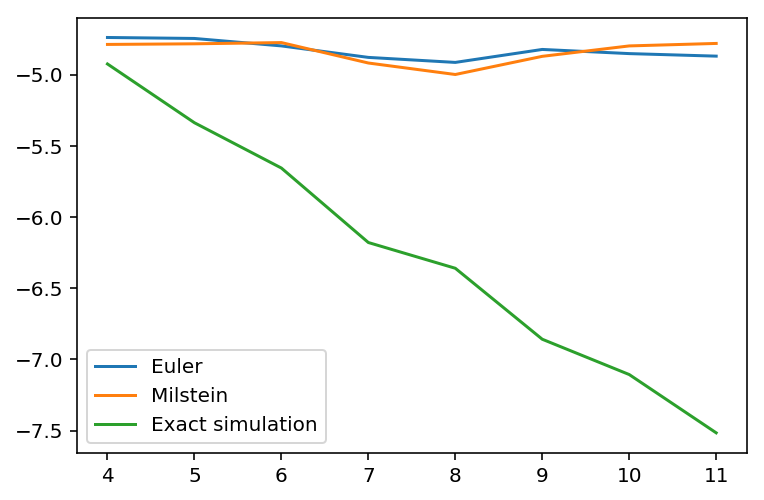

In [7]:
if __name__ == '__main__':
    
    #OU process
    a=2.11
    b=0.02
    mu = lambda x, t: a*(b-x)
    sigma = lambda x, t: 0.033
    sig=0.033
    x0 = 0.005
   
    iSDE = SDE(mu, sigma, x0)

    ArrLog2Steps = np.arange(8)
    NumMinLog2Steps = 4 

    ArrErr_Euler = np.zeros(ArrLog2Steps.size)
    ArrErr_Milstein = np.zeros(ArrLog2Steps.size)
    ArrErr_Exact = np.zeros(ArrLog2Steps.size)
    T = 1.
    NumSimu = 200
    '''
    Exact price of zero-coupon bond
    '''
    P=iSDE.Bond_Exact(a,b,sig)
    
    for n in ArrLog2Steps:
        NumMesh = np.power(2, n + NumMinLog2Steps)
        errsum_Euler = 0
        errsum_Milstein = 0
        errsum_Exact = 0
        
        deltaT=T/NumMesh
        
        for i in range(NumSimu):
            
            '''
            Euler simulation
            '''            
            [t, Xh, Wh] = iSDE.Euler(T, NumMesh)
            XhT = Xh[-1]
            #XT = iSDE.Explicit(a,b,T,Wh[-1])
            PhT=np.exp(-1.0*deltaT*np.sum(Xh))
            errsum_Euler = errsum_Euler + np.abs(PhT - P)
            #plt.plot(t,Xh)
            '''
            Milstein simulation
            '''            
            [t, Xh, Wh] = iSDE.Milstein(T, NumMesh)
            XhT = Xh[-1]
            #XT = iSDE.Explicit(a,b,T,Wh[-1])
            PhT=np.exp(-1.0*deltaT*np.sum(Xh))         
            errsum_Milstein = errsum_Milstein + np.abs(PhT - P)
            '''
            Exact simulation
            '''            
            
            Xh= iSDE.Exact(a,b,T,sig,NumMesh)
            #XhT = Xh[-1]
            #XT= iSDE.Explicit(a,b,T,Wh[-1])
            
            
            PhT=np.exp(-1.0*deltaT*np.sum(Xh))
            errsum_Exact = errsum_Exact + np.abs(PhT - P)

        ArrErr_Euler[n] = errsum_Euler/NumSimu
        ArrErr_Milstein[n] = errsum_Milstein/NumSimu
        ArrErr_Exact[n] = errsum_Exact/NumSimu        

    
    x_coordinate = ArrLog2Steps+NumMinLog2Steps
    y_coordinate_Euler = np.log(ArrErr_Euler)
    y_coordinate_Milstein = np.log(ArrErr_Milstein)
    y_coordinate_Exact = np.log(ArrErr_Exact)    
    plt.plot(x_coordinate, y_coordinate_Euler,label='Euler')
    plt.plot(x_coordinate, y_coordinate_Milstein,label='Milstein')    
    plt.plot(x_coordinate, y_coordinate_Exact,label='Exact simulation')
    plt.legend()   
    
    lg0 = stats.linregress(x_coordinate,y_coordinate_Euler)
    lg1 = stats.linregress(x_coordinate,y_coordinate_Milstein)    
    lg2 = stats.linregress(x_coordinate,y_coordinate_Exact)
    rate0 = -lg0[0]
    rate1=-lg1[0]
    rate2=-lg2[0]
    print('rate for Euler is '+ str(rate0))
    print('rate for Milstein is '+ str(rate1))        
    print('rate for Exact is '+ str(rate2))        
        